# ResNet50

V tomto notebooku je uvedený náš model vytvorený pomocou konvolučnej neurónovej siete ResNet50 z TensorFlow knižnice. ResNet50 je tzv. reziduálna konvolučná sieť, ktorá je hlboká 50 vrstiev. Reziduálna konvolučná sieť je taká sieť, ktorá na seba ukladá reziduálne bloky a tak vytvára sieť. 

Pomocou nami vytvoreného modelu sme sa snažili klasifikovať dataset obrázkov CIFAR-100, ktorý obsahuje 100 tried obrázkov. Následne sme tento model vyskúšali aj na menšom datasete CIFAR-10.

In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from keras.datasets import cifar100
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

### Načítanie datasetu

In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [3]:
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

### Ukážka dát

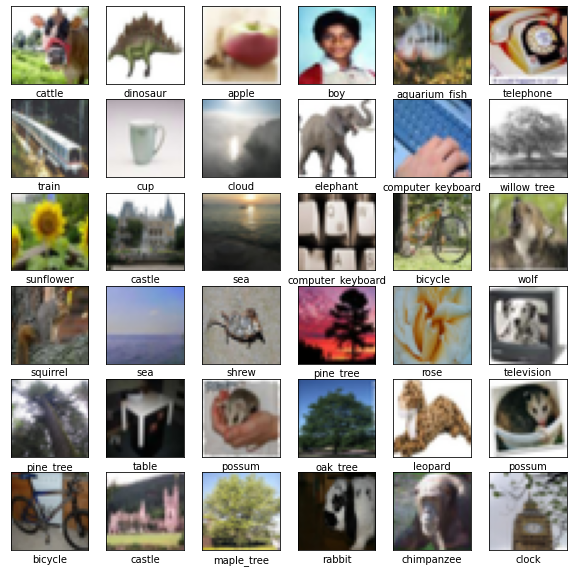

In [4]:
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])

    plt.xlabel(labels[y_train[i][0]])
plt.show()

### Predspracovanie dát

Na predspracovanie dát sme využili funkciu z knižnice TensorFlow, aby sa naše dáta čo najlepšie hodili do požadovanej siete ResNet50.

In [5]:
# pre-process the data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

### Nastavenie augmentácie nášho trénovacieho datasetu

Náš model sme najskôr trénovali bez augmentácie, avšak nemali sme dostatočne dobré výsledky. Z výsledkov nášho starého modelu sme tiež videli, že dochádza k tzv. overfittingu. Preto sme sa rozhodli pridať augmentáciu dát, ktorá dokáže riešiť problém overfittingu tým, že umelo vygeneruje nové obrázky, ktoré sú nejakým spôsobom upravené. V našom prípade sme zvolili horizontálne a vertikálne prevrátenie, rotáciu a posuny šírky a výšky atď.

In [6]:
# Generate augmented images
datagen = ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)
datagen.fit(x_train)

### Rozdelenie testovacích dát na testovacie a validačné

Našu testovaciu množinu dát sme rozdelili na testovaciu a validačnú v pomere 70:30

In [7]:
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.7)

In [8]:
num_classes = 100

y_train = np_utils.to_categorical(y_train, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)
#y_test = np_utils.to_categorical(y_test, num_classes)

## Vytváranie modelu

V tejto časti vytvárame náš konkrétny model. Na vytvorenie modelu používame sieť z TensorFlow knižnice -> teda ResNet50. K tejto sieti následne pridávame ďalšie vrstvy. Skúšali sme viaceré varianty, ale nižšie vytvorený model mal zo všetkých najväčšiu úspešnosť. Ako prvé pridávame vrtsvu GlobalAveragePooling2D, následne pridávame aktivačnú Dense vrstvu s aktivačnou funkciou ReLu, pridávame BatchNormalization a nakoniec máme poslednú Dense vrstvu s aktivačnou funkciou SoftMax.

Keďže sme mali problém s overfittingom nášho modelu, tak sme skúšali pridávať aj Dropout vrstvy, avšak tie nemali nejaký výrazný vplyv na výkon modelu a zlepšenie overfittingu. Tento problém sme vyriešili pridaním augmentácie obrázkov opísanej vyššie.

In [9]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [10]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 100)               2

## Trénovanie modelu

Náš model sa trénoval na 100 epochách. Skúšali sme viacero možností batch size, ale ako najlepšie nám vyšiel batch size s  veľkosťou 64 obrázkov. Pri trénovaní bolo použité EarlyStopping, ktoré bolo nastavené tak, že keď sa 10 epôch po sebe nezlepšila hodnota val_accuracy, tak sa trénovanie ukončilo.

Najlepší model si ukladáme pomocou ModelCheckpointu.

In [12]:
epochs = 100
batch_size = 64

# Set checkpointer and train model
model_checkpointer = ModelCheckpoint('cifar100_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

t=time.time()
history = model.fit(datagen.flow(x_train, y_train,
                                  batch_size=batch_size),
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  epochs=epochs,
                                  validation_data=(x_valid, y_valid),
                                 callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10), model_checkpointer])
print('Training time: %s' % (t - time.time()))

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 3.7763 - accuracy: 0.1525
Epoch 1: val_accuracy improved from -inf to 0.27571, saving model to cifar100_best_model.h5
781/781 [==============================] - 74s 86ms/step - loss: 3.7763 - accuracy: 0.1525 - val_loss: 2.9870 - val_accuracy: 0.2757
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 3.1759 - accuracy: 0.2314
Epoch 2: val_accuracy improved from 0.27571 to 0.31286, saving model to cifar100_best_model.h5
781/781 [==============================] - 64s 82ms/step - loss: 3.1759 - accuracy: 0.2314 - val_loss: 2.7149 - val_accuracy: 0.3129
Epoch 3/100
781/781 [==============================] - ETA: 0s - loss: 2.9598 - accuracy: 0.2674
Epoch 3: val_accuracy improved from 0.31286 to 0.33671, saving model to cifar100_best_model.h5
781/781 [==============================] - 64s 82ms/step - loss: 2.9598 - accuracy: 0.2674 - val_loss: 2.5740 - val_accuracy: 0.3367
Epoch 4/100
781/781 [=======

781/781 [==============================] - 64s 82ms/step - loss: 2.1082 - accuracy: 0.4365 - val_loss: 2.0062 - val_accuracy: 0.4690
Epoch 27/100
781/781 [==============================] - ETA: 0s - loss: 2.1072 - accuracy: 0.4321
Epoch 27: val_accuracy did not improve from 0.46900
781/781 [==============================] - 64s 81ms/step - loss: 2.1072 - accuracy: 0.4321 - val_loss: 1.9904 - val_accuracy: 0.4677
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 2.0995 - accuracy: 0.4339
Epoch 28: val_accuracy did not improve from 0.46900
781/781 [==============================] - 64s 82ms/step - loss: 2.0995 - accuracy: 0.4339 - val_loss: 2.0271 - val_accuracy: 0.4573
Epoch 29/100
781/781 [==============================] - ETA: 0s - loss: 2.0830 - accuracy: 0.4383
Epoch 29: val_accuracy did not improve from 0.46900
781/781 [==============================] - 64s 82ms/step - loss: 2.0830 - accuracy: 0.4383 - val_loss: 2.0125 - val_accuracy: 0.4664
Epoch 30/100
781/7

Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 1.8793 - accuracy: 0.4833
Epoch 55: val_accuracy did not improve from 0.48286
781/781 [==============================] - 64s 81ms/step - loss: 1.8793 - accuracy: 0.4833 - val_loss: 1.9627 - val_accuracy: 0.4783
Epoch 56/100
781/781 [==============================] - ETA: 0s - loss: 1.8824 - accuracy: 0.4850
Epoch 56: val_accuracy did not improve from 0.48286
781/781 [==============================] - 64s 81ms/step - loss: 1.8824 - accuracy: 0.4850 - val_loss: 1.9671 - val_accuracy: 0.4791
Epoch 57/100
781/781 [==============================] - ETA: 0s - loss: 1.8684 - accuracy: 0.4836
Epoch 57: val_accuracy did not improve from 0.48286
781/781 [==============================] - 64s 81ms/step - loss: 1.8684 - accuracy: 0.4836 - val_loss: 1.9610 - val_accuracy: 0.4829
Epoch 57: early stopping
Training time: -3654.141068458557


## Výsledky trénovania

Vidíme, že najlepší model mal validačnú accuracy 0.483, ktorá bola dosiahnutá v epochu č. 47 a keďže v nasledujúcich epochoch nenastalo k jej zlepšeniu bolo použité EarlyStopping trénovania. Tento najlepší model sme  následne uložili pomocou ModelCheckpoint-u. Aj pomocou grafu vidíme, že trénovanie začalo stagnovať okolo hodnoty 0.45 - 0.49 trénovacej accuracy. Ďalšie zlepšenie modelu sa nám nepodarilo docieliť ani s viacerými nastaveniami hyperparametrov a ani upravou siete.

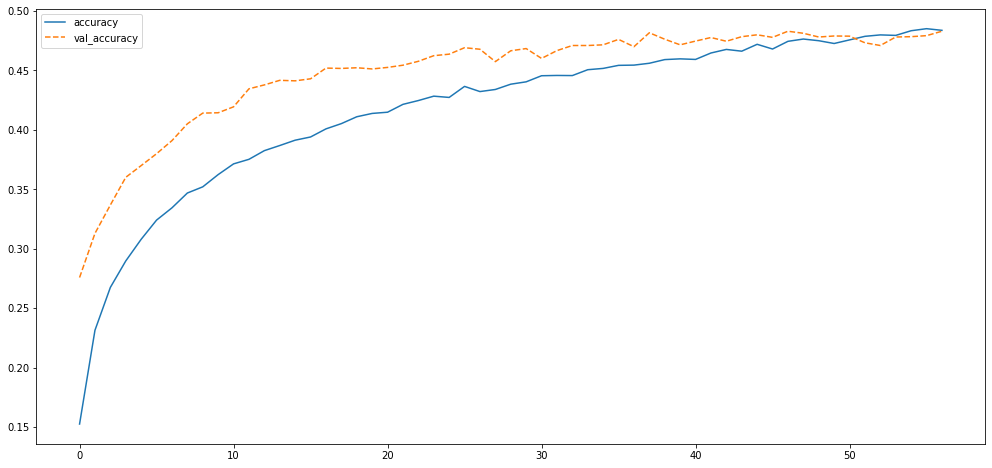

In [41]:
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy', linestyle='--')
plt.legend()

## Testovanie

Pri vyhodnocovaní úspešnosti na testovacích dátach si najskôr načítame najlepší model z trénovania a pomocou funkcie classification_report() model vyhodnotíme. Vidíme, že model mal na testovacích dátach úspešnosť 0.45.

In [13]:
best_model = load_model('cifar100_best_model.h5')

In [14]:
y_pred = best_model.predict(x_test)
y_classes = [np.argmax(element) for element in y_pred]

print('Report: \n', classification_report(y_test, y_classes))

Report: 
               precision    recall  f1-score   support

           0       0.59      0.79      0.68        24
           1       0.65      0.59      0.62        37
           2       0.45      0.44      0.44        32
           3       0.67      0.12      0.21        32
           4       0.18      0.28      0.22        25
           5       0.48      0.52      0.50        29
           6       0.56      0.60      0.58        25
           7       0.31      0.44      0.36        25
           8       0.38      0.50      0.43        26
           9       0.62      0.65      0.64        23
          10       0.53      0.32      0.40        28
          11       0.38      0.19      0.26        31
          12       0.52      0.46      0.49        28
          13       0.26      0.35      0.30        34
          14       0.32      0.36      0.34        28
          15       0.38      0.20      0.26        30
          16       0.45      0.61      0.52        28
          17     

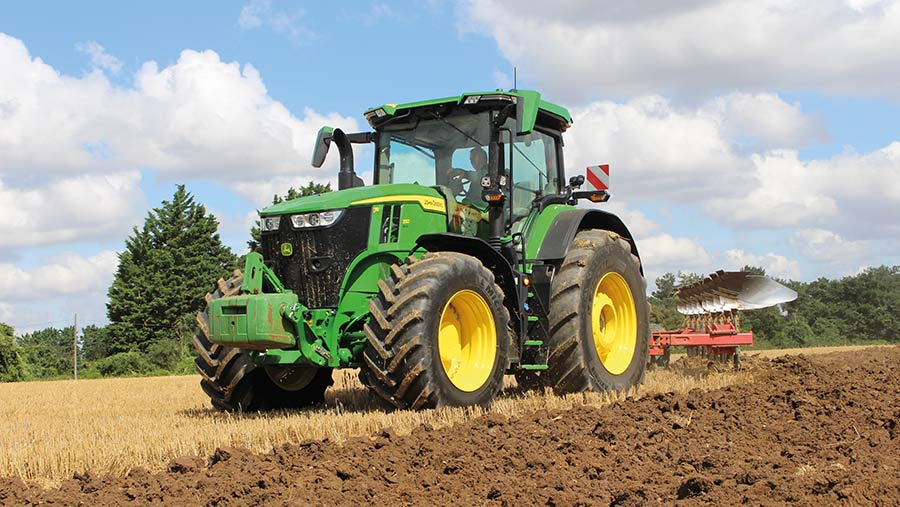

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

load_img('data/tractor.jpg')

In [17]:
labels_names = []
for i in range(len(labels)):
    labels_names += [i]
    
reverse_mapping = dict(zip(labels_names, labels)) 

def mapper(value):
    return reverse_mapping[value]

In [37]:
# Pre-process image
image_1 = load_img('data/tractor.jpg', target_size=(32, 32))
image_1 = img_to_array(image_1) 
image_1 = image_1
prediction_image_1 = np.array(image_1)
prediction_image_1 = np.expand_dims(image_1, axis=0)

In [38]:
# Get prediction
prediction_1 = model.predict(prediction_image_1)

value_1 = np.argmax(prediction_1)
name_1 = mapper(value_1)
print(f'Prediction is {name_1}.')

Prediction is computer_keyboard.


In [39]:
# Pre-process image
image = load_img('data/fox.jpg', target_size=(32, 32))
image = img_to_array(image) 
image = image
prediction_image = np.array(image)
prediction_image = np.expand_dims(image, axis=0)

In [40]:
# Get prediction
prediction = model.predict(prediction_image)

value = np.argmax(prediction)
name = mapper(value)
print(f'Prediction is {name}.')

Prediction is trout.
